### Chapter 2 연습문제

이번 노트북은 Chapter 2의 연습문제를 풀어보는 노트북이다.

먼저, 데이터를 불러오는 코드를 작성해보자.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join("/content/datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

import tarfile
import gzip
from urllib import request

def fetching_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  os.makedirs(housing_path, exist_ok=True)
  tgz_path = os.path.join(housing_path, 'housing.tgz')
  request.urlretrieve(housing_url, tgz_path)
  with tarfile.open(tgz_path) as f:
    f.extractall(path=housing_path)

fetching_housing_data()
csv_path = os.path.join(HOUSING_PATH, 'housing.csv')
housing = pd.read_csv(csv_path)

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


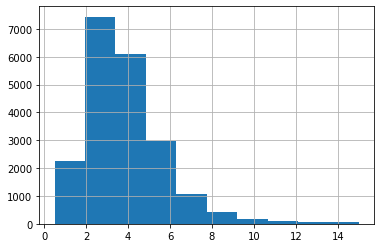

In [ ]:
housing['median_income'].hist(bins=10)

housing 데이터를 `train_test_split()` 함수로 계층적 샘플링을 활용하여 train_set, test_set으로 구분하고, 계층적 샘플링이 올바르게 진행이 되었는지 확인한다.

In [3]:
housing['income_cat'] = pd.cut(
    housing['median_income'],
    bins = [0., 1.5, 3., 4.5, 6., np.inf],
    labels = [1, 2, 3, 4, 5]
)

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, stratify=housing['income_cat'], random_state=42)

stratified_check = pd.DataFrame({
    'overall' : housing['income_cat'].value_counts() / len(housing['income_cat']),
    'train_set' : train_set['income_cat'].value_counts() / len(train_set['income_cat']),
    'test_set' : test_set['income_cat'].value_counts() / len(test_set['income_cat'])
})
stratified_check

,overall,train_set,test_set
3,0.350581,0.350594,0.350533
2,0.318847,0.318859,0.318798
4,0.176308,0.176296,0.176357
5,0.114438,0.114402,0.114583
1,0.039826,0.039850,0.039729


train_set의 데이터를 입력 데이터와, 라벨링 데이터로 구분한다.

In [4]:
train_set.drop('income_cat', axis=1, inplace=True)
test_set.drop('income_cat', axis=1, inplace=True)

housing = train_set.drop('median_house_value', axis=1)
housing_labels = train_set['median_house_value'].copy()

housing.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


`TransformerMixin`과 `BaseEstimator` 클래스를 상속받아, 나만의 transformer를 커스텀한다.

In [5]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator

# 열 인덱스
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room=True):
    self.add_bedrooms_per_room = add_bedrooms_per_room

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]

    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]


attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(train_set.to_numpy())

housing_extra_attribs.shape

(16512, 12)

데이터를 전처리하는 파이프라인을 구축한 뒤, 실제로 전처리를 진행한다.

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
  ('imputer', SimpleImputer(strategy='median')),
  ('attribs_adder', CombinedAttributesAdder()),
  ('std_scaler', StandardScaler()),
])

housing_num = housing.drop('ocean_proximity', axis=1)
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
  ('num', num_pipeline, num_attribs),
  ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

### 1.

서포트 벡터 머신 회귀(`sklearn.svm.SVR`)로 학습을 시도해보자.

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]
svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=10.0, kernel=linear, total=  10.0s
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s


[CV] ............................ C=10.0, kernel=linear, total=   9.9s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.9s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.8s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.9s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   9.7s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   9.7s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=  10.0s
[CV] C=30.0, kernel=linear ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 65.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [8]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

### 2.

`RandomizedSeaerchCV`를 활용하여 학습해보자.

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                    n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                    verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   9.9s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   9.9s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.0s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.0s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.0s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  19.2s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  19.8s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  19.5s
[CV] C=26290.2

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 99.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=50, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f08a2c52290>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f08a2c52550>,
                                        'kernel': ['linear', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=2)

가장 높은 점수의 RMSE를 계산해보자.

In [10]:
negative_score = rnd_search.best_score_
rmse = np.sqrt(-negative_score)
print(rmse)

54767.960710084146


### 3.

가장 중요한 특성을 선택하는 변환기를 준비 파이프라인에 추가해보자.

먼저 `TransformerMixin`과 `BaseEstimator` 클래스를 상속하여, 변환기를 구현한다.

In [64]:
from sklearn.base import TransformerMixin, BaseEstimator

class TopFeatureSelector(BaseEstimator, TransformerMixin):
  def __init__(self, feature_importances, K):
    self.feature_importances = feature_importances
    self.k = K

  def fit(self, X, y=None):
    self.feature_indices_ = np.argsort(self.feature_importances)[-self.k:]
    return self

  def transform(self, X):
    return X[:, self.feature_indices_]

위에서 만든 변환기를 `full_pipeline` 준비 파이프라인에 추가한다.

In [29]:
feature_importances = grid_search.best_estimator_.feature_importances_
K = 5

preparation_and_feature_selection_pipeline = Pipeline([
  ('preparation', full_pipeline),
  ('feature_selection', TopFeatureSelector(feature_importances, K))
])

housing_feature_selected = preparation_and_feature_selection_pipeline.fit_transform(housing)

housing_feature_selected[:3]

array([[ 0.77194962, -1.15604281, -0.08649871,  0.        , -0.61493744],
       [ 0.6596948 , -1.17602483, -0.03353391,  0.        ,  1.33645936],
       [-1.34218285,  1.18684903, -0.09240499,  0.        , -0.5320456 ]])

`housing_prepared` 데이터에서 직접 K개를 뽑아, 위의 결과와 같은지 확인해본다.

In [32]:
feature_indices = np.argsort(feature_importances)[-K:]

housing_prepared[:3, feature_indices]

array([[ 0.77194962, -1.15604281, -0.08649871,  0.        , -0.61493744],
       [ 0.6596948 , -1.17602483, -0.03353391,  0.        ,  1.33645936],
       [-1.34218285,  1.18684903, -0.09240499,  0.        , -0.5320456 ]])

### 4.

전체 데이터 준비 과정과 최종 예측을 하나의 파이프라인으로 만들어보자.

파이프라인을 구축한 뒤, 학습을 진행해본다.

In [39]:
entitle_pipeline = Pipeline([
  ('preparation', full_pipeline),
  ('feature_selection', TopFeatureSelector(feature_importances, K)),
  ('svm_reg', SVR(**rnd_search.best_params_))
])

entitle_pipeline.fit(housing, housing_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                              

실제로, 예측이 잘되고 있는지 확인해본다.

In [42]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
prediction = entitle_pipeline.predict(some_data)
prediction

array([203214.28978849, 371846.88152573, 173295.65441611,  47328.39708881,
       205813.89296351])

In [46]:
np.array(some_labels)

array([286600., 340600., 196900.,  46300., 254500.])

위 두 배열이 얼추 비슷한 것을 보면, 예측이 어느정도 되는 것을 확인할 수 있다. (물론 성능이 좋지는 않다.)

### 5.

GridSearchCV를 사용해 준비 단계의 옵션을 자동으로 탐색해보자.

In [ ]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__K': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(entitle_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)